In [1]:

import pandas as pd
import sys
from pathlib import Path
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL


# adiciona a pasta src ao sys.path
sys.path.append(str(Path.cwd().parent.parent / "src")) # Necessário contar quantos niveis subir nas pastas, incluir 1 .parent para cada nivel.

# Importa o script paths de utils para geracão de caminhos absolutos
from utils.paths import resolve_env_path, PROJECT_ROOT
from classes.time_series_dataset import TimeSeriesDataset
from classes.plotter import Plotter
from utils.calculations import plot_stl_decomposition

# Adiciona caminhos importantes
ARRIVALS_PATH = resolve_env_path("ARRIVALS_PATH")

# Selecting seaborn theme
sns.set_theme(
    style="ticks",
    palette="pastel",
    context="notebook"
)


In [2]:
arrivals_dataset = TimeSeriesDataset(ARRIVALS_PATH)

### Category - Id equivalence tables:

#### Continents:

In [3]:
arrivals_dataset.continent_table

,continent,continent_id
0,africa,1
1,america_central_e_caribe,2
2,america_do_norte,3
3,america_do_sul,4
4,asia,5
5,europa,6
6,oceania,7
7,continente_nao_especificado,8


#### Entry routes

In [4]:
arrivals_dataset.entry_route_table

,entry_route,entry_route_id
0,terrestre,2
1,fluvial,4
2,aereo,1
3,maritimo,3


#### States

In [5]:
arrivals_dataset.state_table

,state,state_id
0,acre,1
1,amapa,3
2,amazonas,4
3,bahia,5
4,ceara,6
5,distrito_federal,7
6,mato_grosso_do_sul,12
7,minas_gerais,13
8,para,14
9,parana,16


In [6]:
df =  arrivals_dataset.get_data_without_missing_values()
df.head()

,continent,continent_id,country,country_id,state,state_id,entry_route,entry_route_id,year,month,month_id,arrivals,file_index,date
0,africa,1,africa_do_sul,2,acre,1,terrestre,2,2015,janeiro,1,2.0,file_0,2015-01-01
1,africa,1,angola,6,acre,1,terrestre,2,2015,janeiro,1,0.0,file_0,2015-01-01
2,africa,1,cabo_verde,35,acre,1,terrestre,2,2015,janeiro,1,0.0,file_0,2015-01-01
3,africa,1,egito,60,acre,1,terrestre,2,2015,janeiro,1,0.0,file_0,2015-01-01
4,africa,1,gana,77,acre,1,terrestre,2,2015,janeiro,1,0.0,file_0,2015-01-01


Our scope of analysis is Rio de Janeiro, so we'll filter only that state. Also, our aggregation categories are date, continent and entry route.

In [7]:
def process_df(df:pd.DataFrame, state:str, agg_cols:list, value_cols:list, agg_func:Callable) -> pd.DataFrame:
    df = df.copy()

    # Filter Rio de Janeiro
    df = df.loc[df["state"] == state, :]

    # Group by desired columns
    return df.groupby(agg_cols)[value_cols].agg(agg_func).reset_index()


In [10]:
df_rj = process_df(df=df, state="rio_de_janeiro", agg_cols=["date","continent","continent_id", "entry_route","entry_route_id", "year", "month", "month_id"], value_cols="arrivals", agg_func=np.sum)

C:\Users\f0oo\AppData\Local\Temp\ipykernel_32296\2703529039.py:8: FutureWarning: The provided callable <function sum at 0x000001C439FB0360> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  return df.groupby(agg_cols)[value_cols].agg(agg_func).reset_index()


In [11]:
df_rj

,date,continent,continent_id,entry_route,entry_route_id,year,month,month_id,arrivals
0,2000-01-01,africa,1,aereo,1,2000,janeiro,1,1598.0
1,2000-01-01,africa,1,maritimo,3,2000,janeiro,1,69.0
2,2000-01-01,america_central_e_caribe,2,aereo,1,2000,janeiro,1,359.0
3,2000-01-01,america_central_e_caribe,2,maritimo,3,2000,janeiro,1,90.0
4,2000-01-01,america_do_norte,3,aereo,1,2000,janeiro,1,19924.0
...,...,...,...,...,...,...,...,...,...
4174,2024-12-01,asia,5,maritimo,3,2024,dezembro,12,103.0
4175,2024-12-01,europa,6,aereo,1,2024,dezembro,12,39697.0
4176,2024-12-01,europa,6,maritimo,3,2024,dezembro,12,284.0
4177,2024-12-01,oceania,7,aereo,1,2024,dezembro,12,1621.0


In [12]:

# Adjusting schema
df_rj["entry_route_id"] = df_rj["entry_route_id"].astype("category")
df_rj["continent_id"] = df_rj["continent_id"].astype("category")
df_rj["arrivals"] = df_rj["arrivals"].astype("Int64")
df_rj["month"] = pd.Categorical(
    df_rj["month"],
    df_rj["month"].unique().tolist(),
    ordered=True
    )



In [13]:
df_rj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4179 entries, 0 to 4178
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            4179 non-null   datetime64[ns]
 1   continent       4179 non-null   object        
 2   continent_id    4179 non-null   category      
 3   entry_route     4179 non-null   object        
 4   entry_route_id  4179 non-null   category      
 5   year            4179 non-null   int64         
 6   month           4179 non-null   category      
 7   month_id        4179 non-null   int64         
 8   arrivals        4179 non-null   Int64         
dtypes: Int64(1), category(3), datetime64[ns](1), int64(2), object(2)
memory usage: 213.2+ KB


We'll also instantiate an object of class Plotter in order to make plots for the EDA.

In [14]:
plotter = Plotter()

## Exploratory Data Analysis

### Arrivals time series

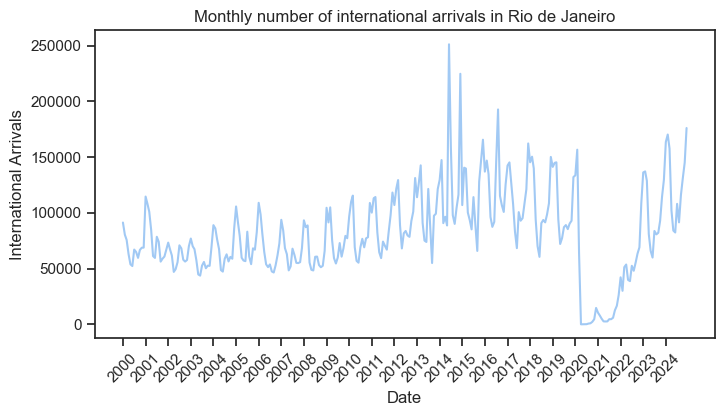

In [15]:
fig, ax = plotter.plot(
    data=df_rj,
    plot_name="lineplot",
    x="date",
    y="arrivals",
    estimator="sum",
    errorbar=None,
    x_label="Date",
    y_label = "International Arrivals",
    title="Monthly number of international arrivals in Rio de Janeiro"
    )

years = pd.date_range(start=df_rj["date"].min(), end=df_rj["date"].max(), freq="YS")
ax.set_xticks(years)             # posições no eixo (datetime)
ax.set_xticklabels(years.year)   # rótulos como ano
ax.tick_params(axis="x", rotation=45)

plt.show()

Clearly, between 2020 and 2021 tourism died.

### Time series behaviour by month since 2018 (excluding 2020 and 2021 because of covid)

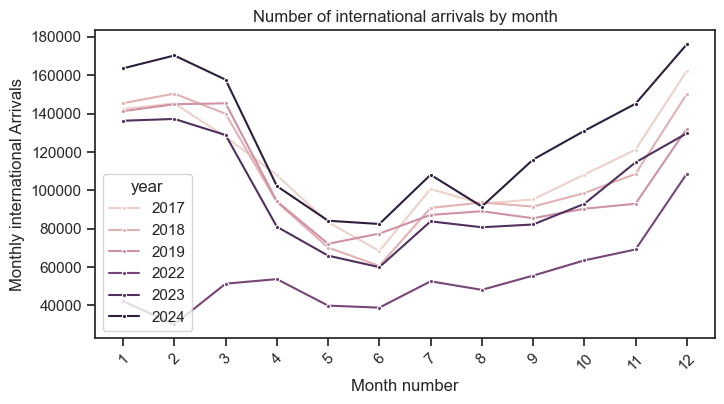

In [16]:
fig, ax = plotter.plot(
    data=df_rj[df_rj["year"].isin([2017, 2018, 2019, 2022, 2023, 2024])],
    plot_name="lineplot",
    x="month_id",
    y="arrivals",
    hue="year",
    estimator="sum",
    errorbar=None,
    x_label="Month number",
    y_label = "Monthly international Arrivals",
    title="Number of international arrivals by month",
    marker="."
    )

ax.tick_params(axis="x", rotation=45)
ax.set_xticks(np.arange(1, 13,1))

plt.show()

Looking at the time series of each year it is possible to notice that by 2022 international arrivals were still significantly lower than pre-covid. Also, it is clear that, on that year, the seasonal changes were still different than what is perceived historical patterns.

That said, it is also clear that since 2023 the seasonal variations show similar patterns noticed on pre-covid years.

### International arrivals by entry route

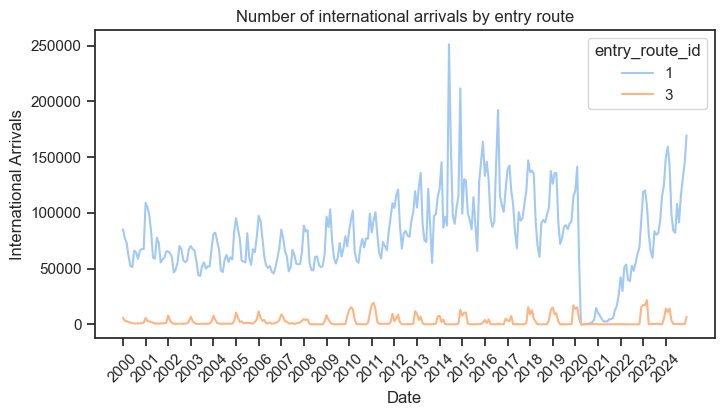

In [17]:
fig, ax = plotter.plot(
    data=df_rj,
    plot_name="lineplot",
    x="date",
    y="arrivals",
    hue="entry_route_id",
    estimator="sum",
    errorbar=None,
    x_label="Date",
    y_label = "International Arrivals",
    title="Number of international arrivals by entry route"
    )

years = pd.date_range(start=df_rj["date"].min(), end=df_rj["date"].max(), freq="YS")
ax.set_xticks(years)             # posições no eixo (datetime)
ax.set_xticklabels(years.year)   # rótulos como ano
ax.tick_params(axis="x", rotation=45)

plt.show()

It's easy to spot that the tourism almost ceased to exist between 2020 and 2022 because of the COVID-19 pandemic. Therefore, in order to build a predictive model, we'll need to do some workaround in order to deal with that period of time.

### Yearly time series of arrivals by entry route type.

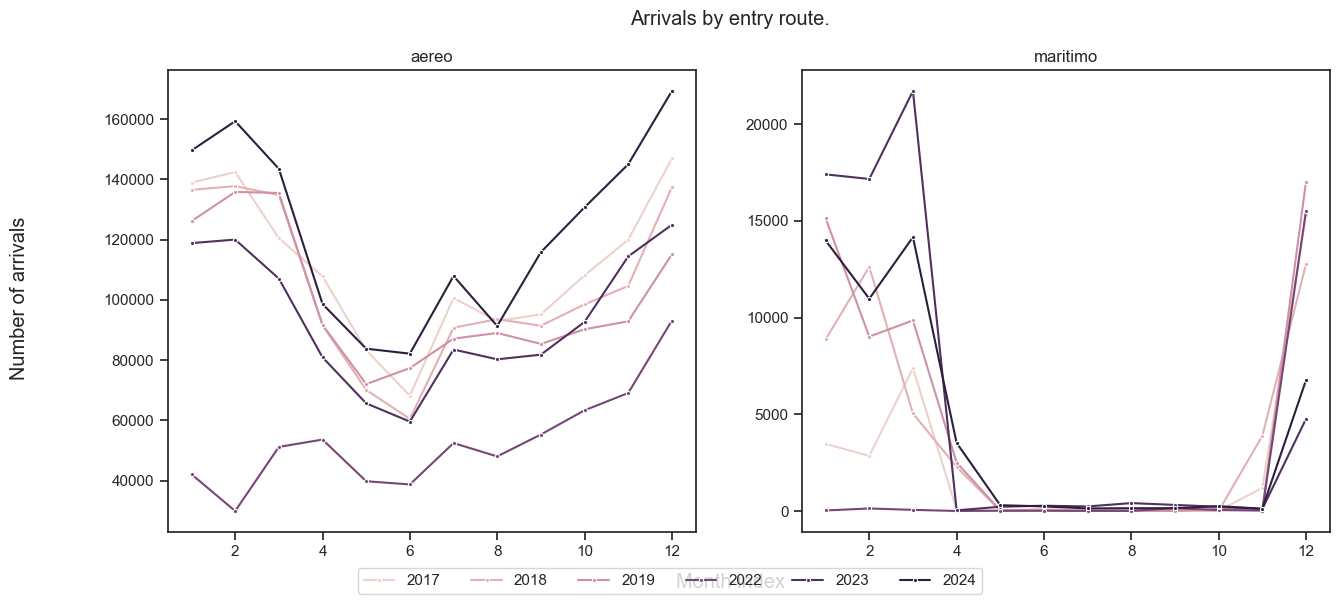

In [18]:
n_entry_routes = df_rj["entry_route"].nunique()

fig, axs = plt.subplots(1, n_entry_routes,sharex=True, figsize=(15, 6))

temp_df = df_rj[df_rj["year"].isin([2017, 2018, 2019, 2022, 2023, 2024])]

for i, entry_route in enumerate(df_rj["entry_route"].unique()):
    entry_route_df = temp_df.loc[temp_df["entry_route"] == entry_route, :]
    _ax = plotter.plot(
    data=entry_route_df,
    ax=axs[i],
    plot_name="lineplot",
    x="month_id",
    y="arrivals",
    hue="year",
    estimator="sum",
    errorbar=None,
    # y_label = "Monthly international Arrivals",
    marker=".",
    title=entry_route
    )

    # remove a legenda local
    if i < n_entry_routes:
        axs[i].get_legend().remove()

# cria uma legenda global com base no último ax
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(labels))
fig.suptitle("Arrivals by entry route.")
fig.supxlabel("Month index")
fig.supylabel("Number of arrivals")

plt.show()

There are almost no sea arrivals from months 5 to 11.

### Internationals arrivals by continent

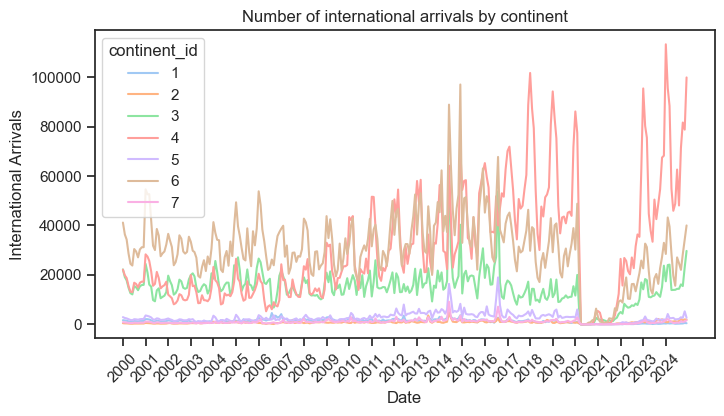

In [19]:
fig, ax = plotter.plot(
    data=df_rj,
    plot_name="lineplot",
    x="date",
    y="arrivals",
    hue="continent_id",
    estimator="sum",
    errorbar=None,
    x_label="Date",
    y_label = "International Arrivals",
    title="Number of international arrivals by continent"
    )

years = pd.date_range(start=df_rj["date"].min(), end=df_rj["date"].max(), freq="YS")
ax.set_xticks(years)             # posições no eixo (datetime)
ax.set_xticklabels(years.year)   # rótulos como ano
ax.tick_params(axis="x", rotation=45)

plt.show()

It is possible to note that, at least since the pandemic, most of the tourists are from latin america, followed by europeans and north americans.

### Yearly arrivals time series by continent.

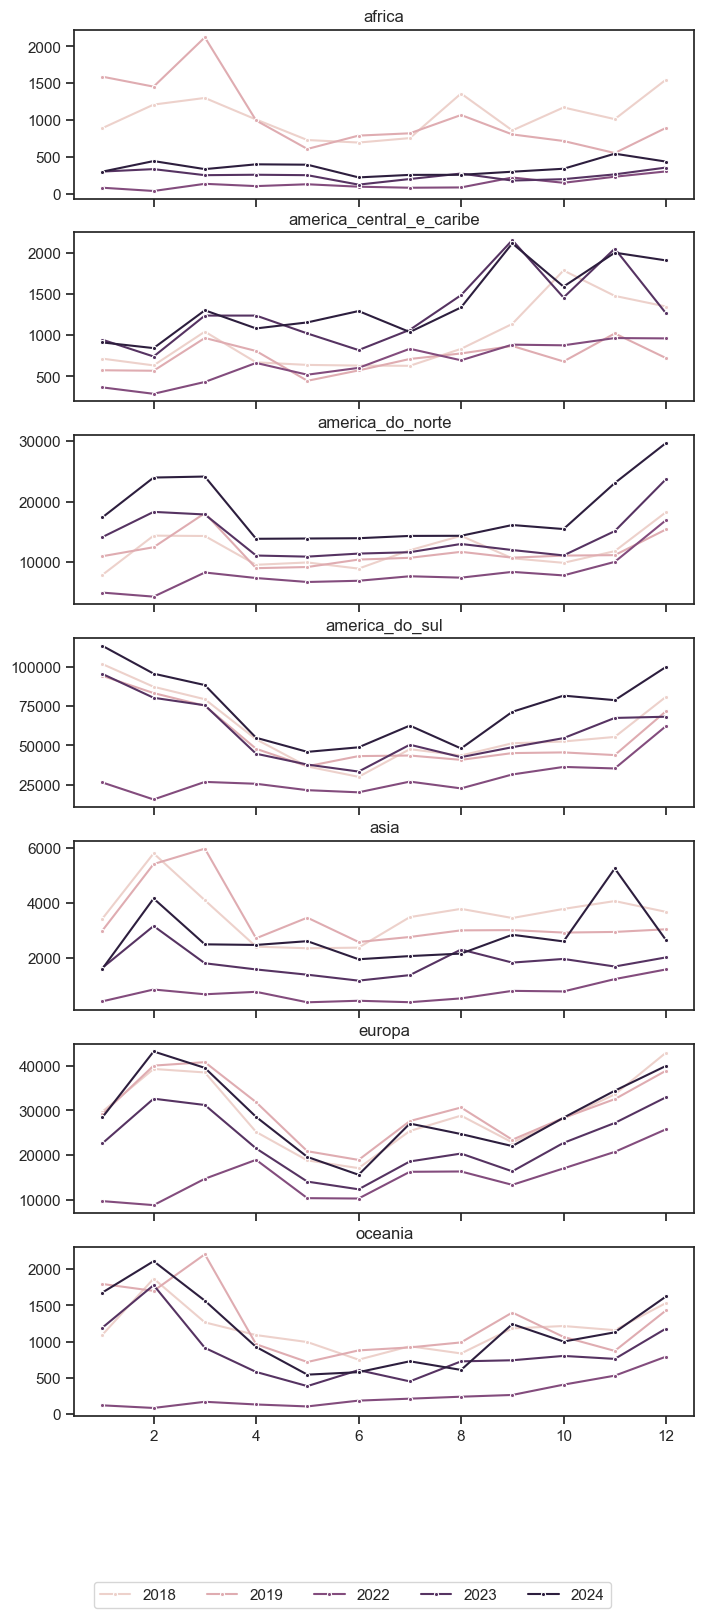

In [20]:
n_continents = df_rj["continent_id"].nunique()

fig, axs = plt.subplots(n_continents, 1, sharex=True, figsize=(8, 18))

temp_df = df_rj[df_rj["year"].isin([2018, 2019, 2022, 2023, 2024])]

for i, continent in enumerate(df_rj["continent"].unique()):
    continent_df = temp_df.loc[temp_df["continent"] == continent, :]
    _ax = plotter.plot(
    data=continent_df,
    ax=axs[i],
    plot_name="lineplot",
    x="month_id",
    y="arrivals",
    hue="year",
    estimator="sum",
    errorbar=None,
    # y_label = "Monthly international Arrivals",
    marker=".",
    title=continent
    )

    # remove a legenda local
    if i < n_continents:
        axs[i].get_legend().remove()

# cria uma legenda global com base no último ax
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(labels))

plt.show()

Excluding Central America (which is the less represented continent, along with Africa and Oceania), every continent follow more o less the same seasonal pattern, with spikes in the beginning and the end of the year.

### ACF plots

All analysis show that 2022 was still not a typical year, so we'll use data from 2023 onwards

In [21]:
df_pre_covid = df_rj[df_rj["date"] <= "2019-12-01"]
df_post_covid = df_rj[df_rj["date"] >= "2022-12-01"]

In [22]:
df_post_covid

,date,continent,continent_id,entry_route,entry_route_id,year,month,month_id,arrivals
3850,2022-12-01,africa,1,aereo,1,2022,dezembro,12,301
3851,2022-12-01,africa,1,maritimo,3,2022,dezembro,12,5
3852,2022-12-01,america_central_e_caribe,2,aereo,1,2022,dezembro,12,923
3853,2022-12-01,america_central_e_caribe,2,maritimo,3,2022,dezembro,12,38
3854,2022-12-01,america_do_norte,3,aereo,1,2022,dezembro,12,16651
...,...,...,...,...,...,...,...,...,...
4174,2024-12-01,asia,5,maritimo,3,2024,dezembro,12,103
4175,2024-12-01,europa,6,aereo,1,2024,dezembro,12,39697
4176,2024-12-01,europa,6,maritimo,3,2024,dezembro,12,284
4177,2024-12-01,oceania,7,aereo,1,2024,dezembro,12,1621


In [23]:
# Calculating aggregated arrivals
df_pre_full = df_pre_covid.groupby("date")["arrivals"].sum().reset_index()
df_post_full = df_post_covid.groupby("date")["arrivals"].sum().reset_index()


In [24]:
df_post_full

,date,arrivals
0,2022-12-01,108658
1,2023-01-01,136256
2,2023-02-01,137200
3,2023-03-01,128797
4,2023-04-01,80984
5,2023-05-01,65886
6,2023-06-01,59894
7,2023-07-01,83775
8,2023-08-01,80697
9,2023-09-01,82149


#### Pre covid ACF

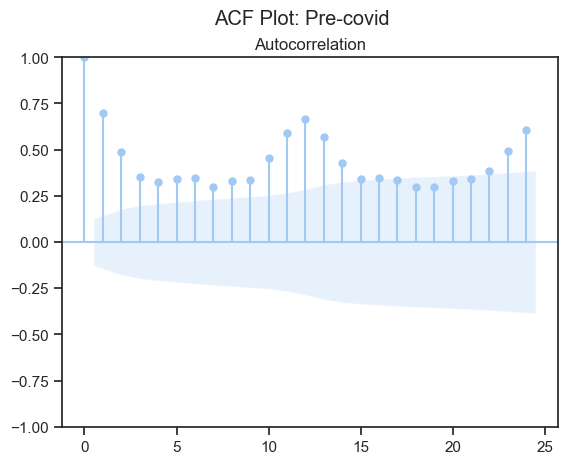

In [25]:
fig = plot_acf(df_pre_full["arrivals"], lags=24)
fig.suptitle("ACF Plot: Pre-covid")
plt.show()

### Post covid ACF 

TODO: Include 2025 data in order to run this plot again.

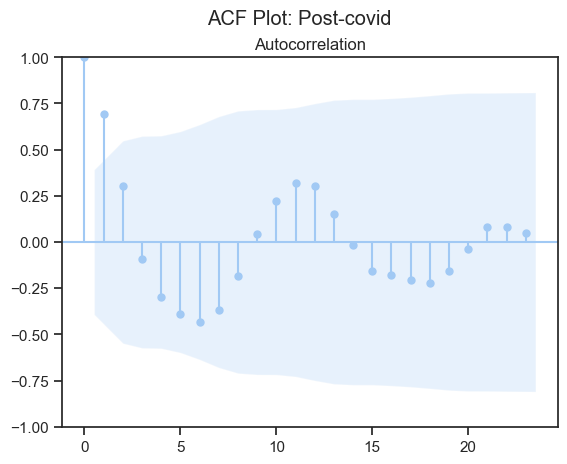

In [26]:
fig = plot_acf(df_post_full["arrivals"], lags=23)
fig.suptitle("ACF Plot: Post-covid ")
plt.show()

### STL Decomposition

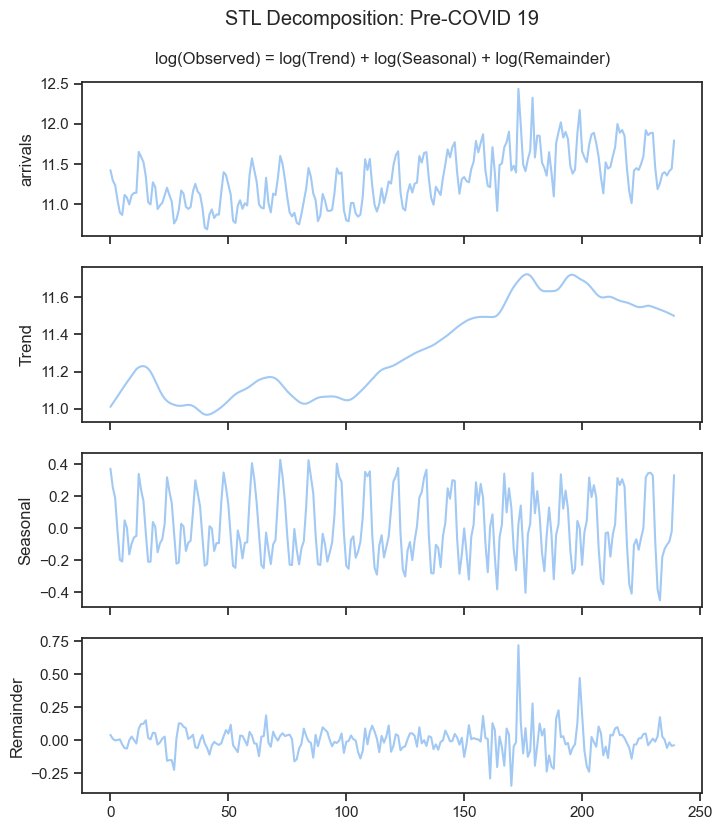

In [27]:
pre_covid_stl = plot_stl_decomposition(df=df_pre_full, value_col="arrivals", date_col="date", period=12, title="STL Decomposition: Pre-COVID 19", log=True)

In [28]:
pre_covid_stl

,ds,data,trend,seasonal,remainder,data_original_scale,trend_original_scale,seasonal_original_scale,remainder_original_scale,detrend_original_scale
0,2000-01-01,11.422103,11.010063,0.371388,0.040652,91318.0,60479.697624,1.449745,1.041490,1.509895
1,2000-02-01,11.295068,11.029033,0.255555,0.010479,80424.0,61637.971322,1.291179,1.010534,1.30478
2,2000-03-01,11.234745,11.048100,0.188325,-0.001681,75716.0,62824.498882,1.207226,0.998321,1.205199
3,2000-04-01,11.050207,11.067206,-0.018410,0.001412,62957.0,64036.316482,0.981758,1.001413,0.983145
4,2000-05-01,10.894051,11.086275,-0.198233,0.006009,53855.0,65269.177045,0.820178,1.006027,0.825121
...,...,...,...,...,...,...,...,...,...,...
235,2019-08-01,11.396908,11.522943,-0.129661,0.003627,89046.0,101006.759492,0.878393,1.003633,0.881585
236,2019-09-01,11.355183,11.517527,-0.103892,-0.058452,85407.0,100461.221780,0.901323,0.943224,0.850149
237,2019-10-01,11.411657,11.511728,-0.083797,-0.016274,90369.0,99880.284721,0.919618,0.983857,0.904773
238,2019-11-01,11.439903,11.505512,-0.021760,-0.043850,92958.0,99261.407478,0.978475,0.957098,0.936497


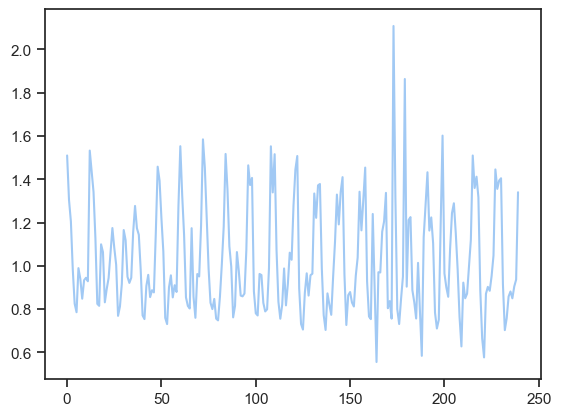

In [29]:
pre_covid_stl["detrend_original_scale"].plot()
plt.show()

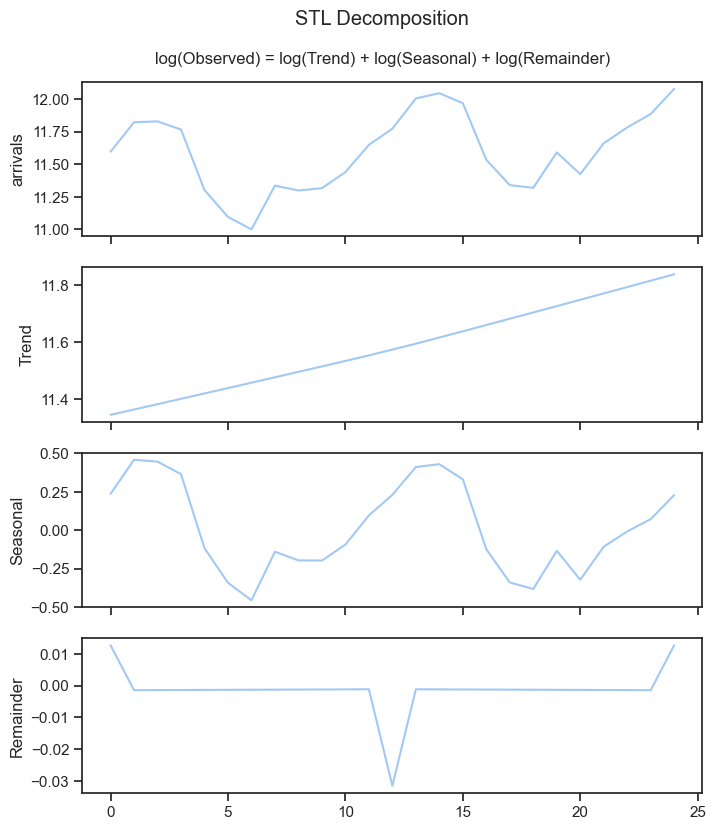

In [30]:
post_covid_stl = plot_stl_decomposition(df=df_post_full, value_col="arrivals", date_col="date", period=12, log=True)

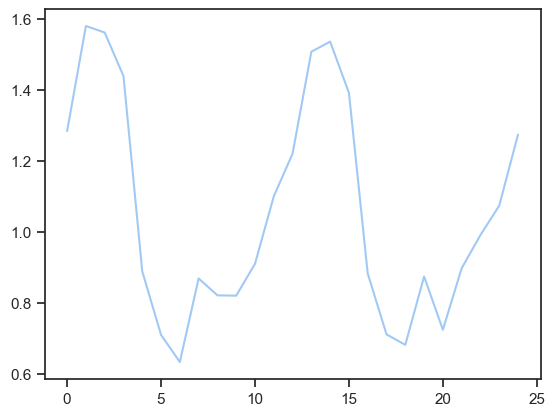

In [31]:
post_covid_stl["detrend_original_scale"].plot()
plt.show(

)

### STL Decomposition for the entire dataset (including COVID period)

In [32]:
# Calculating aggregated arrivals for the entire dataset (all years)
df_full_all_years = df_rj.groupby("date")["arrivals"].sum().reset_index()

print(f"Dataset period: {df_full_all_years['date'].min()} to {df_full_all_years['date'].max()}")
print(f"Total observations: {len(df_full_all_years)}")
df_full_all_years.head()

Dataset period: 2000-01-01 00:00:00 to 2024-12-01 00:00:00
Total observations: 300


,date,arrivals
0,2000-01-01,91318
1,2000-02-01,80424
2,2000-03-01,75716
3,2000-04-01,62957
4,2000-05-01,53855


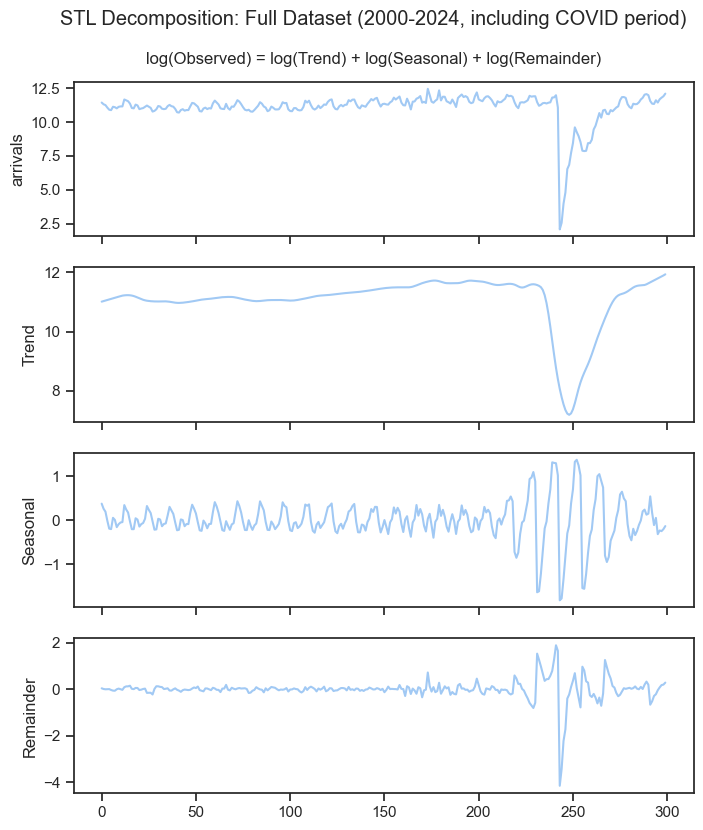

In [ ]:
full_dataset_stl = plot_stl_decomposition(
    df=df_full_all_years,
    value_col="arrivals",
    date_col="date",
    period=12,
    title="STL Decomposition: Full Dataset (2000-2024, including COVID period)",
    log=True
)

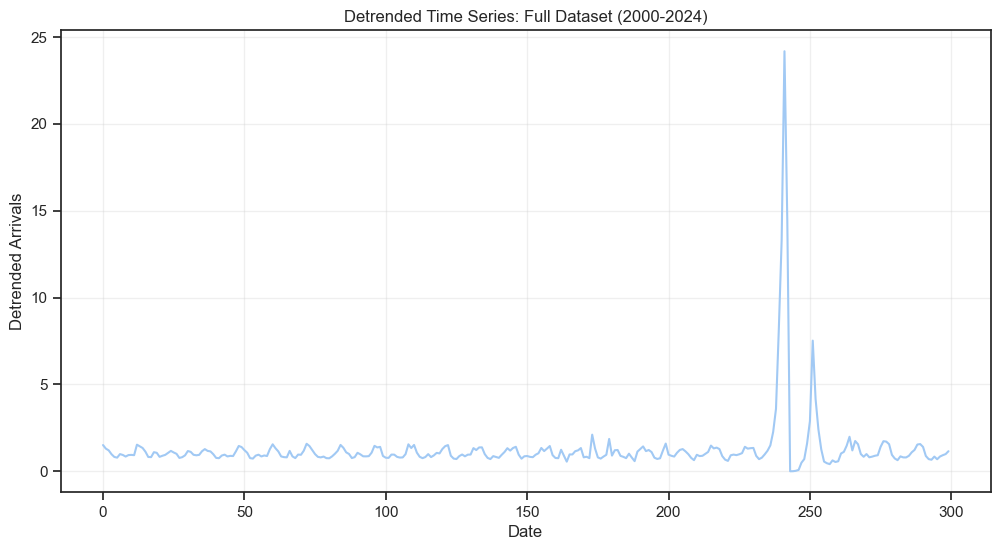

In [34]:
full_dataset_stl["detrend_original_scale"].plot(figsize=(12, 6))
plt.title("Detrended Time Series: Full Dataset (2000-2024)")
plt.xlabel("Date")
plt.ylabel("Detrended Arrivals")
plt.grid(True, alpha=0.3)
plt.show()

### ACF plot for the entire dataset (2000-2024)

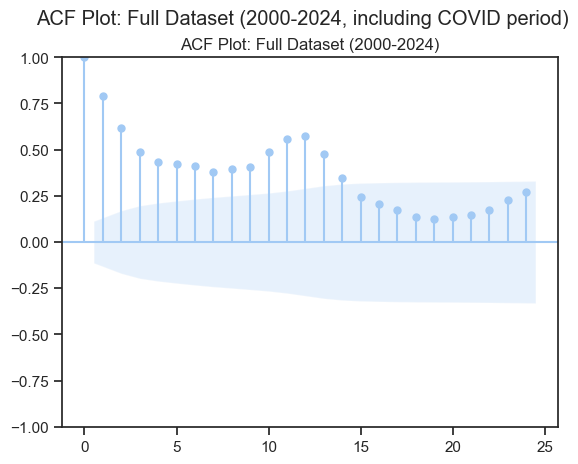

In [35]:
fig = plot_acf(df_full_all_years["arrivals"], lags=24, title="ACF Plot: Full Dataset (2000-2024)")
fig.suptitle("ACF Plot: Full Dataset (2000-2024, including COVID period)")
plt.show()